# Adrian Zaręba | 320672
### KOH Neural Network

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import time
from sklearn.metrics import silhouette_score

## | Dane

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    columns = ['x', 'y']
    if 'z' in df.columns:
        columns.append('z')
    return df[columns].to_numpy(), df['c'].to_numpy()

cube_data, cube_labels = load_data('cube.csv')
hexagon_data, hexagon_labels = load_data('hexagon.csv')

def plot_data_side_by_side(data1, labels1, title1, data2, labels2, title2):
    fig = make_subplots(rows=1, cols=2, subplot_titles=[title1, title2],
                        specs=[[{'type': 'scatter3d'}, {'type': 'scatter'}]])
    fig.add_trace(go.Scatter3d(x=data1[:, 0], y=data1[:, 1], z=data1[:, 2],
        mode='markers',
        marker=dict(size=5, color=labels1, colorscale='Viridis', opacity=0.8)), row=1, col=1)
    fig.add_trace(go.Scatter(x=data2[:, 0], y=data2[:, 1],
        mode='markers',
        marker=dict(size=5, color=labels2, colorscale='Viridis', opacity=0.8)), row=1, col=2)
    fig.update_layout(width=1100,height=550)
    fig.show()

plot_data_side_by_side(cube_data, cube_labels, "Cube", hexagon_data, hexagon_labels, "Hexagon")

#### MNIST

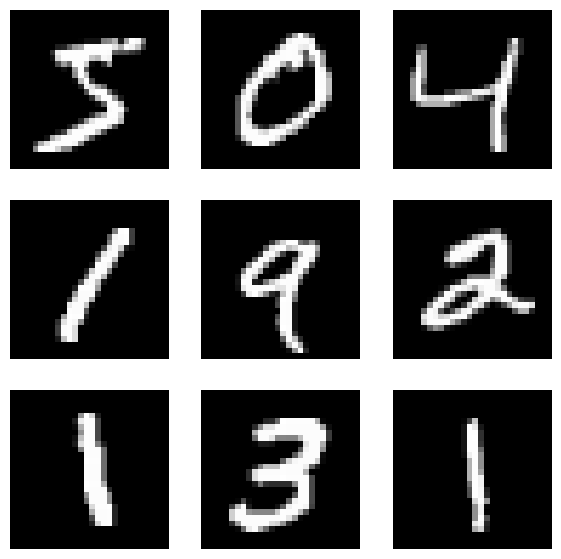

In [3]:
from keras.datasets import mnist
(MNIST_data, MNIST_labels), (MNIST_data_test, MNIST_labels_test) = mnist.load_data()
plt.figure(figsize=(7, 7))
for i in range(9):  
    plt.subplot(3, 3, i + 1)
    plt.imshow(MNIST_data[i], cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

#### HARUS (Human Activity Recognition Using Smartphones)

In [4]:
def read_data(filename):
    with open(filename, 'r') as file:
        data = []
        for line in file:
            row = [float(x) for x in line.split()]
            data.append(row)
    return np.array(data)

# Example usage:
HARUS_data = read_data('X_train.txt')
HARUS_labels = read_data('y_train.txt').flatten().astype(int)
HARUS_data, HARUS_labels

(array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
          0.17994061, -0.05862692],
        [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
          0.18028889, -0.05431672],
        [ 0.27965306, -0.01946716, -0.11346169, ..., -0.84893347,
          0.18063731, -0.04911782],
        ...,
        [ 0.27338737, -0.01701062, -0.04502183, ..., -0.77913261,
          0.24914484,  0.04081119],
        [ 0.28965416, -0.01884304, -0.15828059, ..., -0.78518142,
          0.24643223,  0.02533948],
        [ 0.35150347, -0.01242312, -0.20386717, ..., -0.78326693,
          0.24680852,  0.03669484]]),
 array([5, 5, 5, ..., 2, 2, 2]))

# KOH (Zaaktualizowana)

In [5]:
class KOH:
    def __init__(self, m, n, dim, alpha=0.3, sigma=None, lambda_=100, neighborhood_func="gaussian", topology='rectangular'):
        """
        Inicjuje KOH z podanymi parametrami.
        Argumenty:
            m (int): Liczba wierszy w siatce KOH.
            n (int): Liczba kolumn w siatce KOH.
            dim (int): Wymiarowość danych wejściowych.
            alpha (float): Początkowa szybkość uczenia.
            sigma (float): Początkowa wielkość sąsiedztwa.
            lambda_ (float): Stała czasowa do zanikania.
            neighborhood_func (str): Typ funkcji sąsiedztwa ("gaussian" lub "mexican_hat").
            topology (str): Wybranie topologii sieci.
            weights (np.ndarray): Wagi siatki KOH.
            alpha_decay (function): Funkcja zanikająca szybkość uczenia.
            sigma_decay (float): Tempo zanikania sąsiedztwa.
        """
        self.m = m
        self.n = n
        self.dim = dim
        self.alpha = alpha
        self.sigma = sigma/100 if sigma is not None else max(m, n) / 2
        self.lambda_ = lambda_
        self.neighborhood_func = neighborhood_func
        self.topology = topology
        self.weights = np.random.rand(m, n, dim)
        self.alpha_decay = lambda t: np.exp(-t / self.lambda_)
        self.sigma_decay = 0.99


    def get_bmu(self, x):
        """
        Znajduje najlepszą jednostkę dopasowującą (BMU) dla podanego wektora wejściowego.
        Argumenty:
            x (np.ndarray): Wektor wejściowy.
        Zwraca:
            tuple: Współrzędne BMU w siatce KOH.
        """
        distances = np.linalg.norm(self.weights - x, axis=-1)
        return np.unravel_index(np.argmin(distances), (self.m, self.n))
    

    def hex_distance(self, a, b):
        """
        Oblicza odległość między dwoma punktami w zależności od topologii siatki.
        Argumenty:
            a (tuple): Współrzędne punktu startowego (ax, ay).
            b (tuple): Współrzędne punktu końcowego (bx, by).
        Zwraca:
            float: Obliczoną odległość między punktami w zależności od topologii.
        Wyrzuca:
            ValueError: Jeśli podana topologia nie jest obsługiwana (tylko 'rectangular' lub 'hexagonal').
        """
        ax, ay = a
        bx, by = b
        if self.topology == 'rectangular':
            return np.sqrt((ax - bx) ** 2 + (ay - by) ** 2)
        elif self.topology == 'hexagonal':
            dx = bx - ax
            dy = by - ay
            return max(abs(dx), abs(dy), abs(dx + dy))
        else:
            raise ValueError("Dostępne są tylko dwie topologie: rectangular | hexagonal")


    def get_neighborhood(self, bmu, sigma):
        """
        Tworzy macierz sąsiedztwa wokół podanego BMU (Best Matching Unit) z wykorzystaniem określonej topologii.
        Argumenty:
            bmu (tuple): Współrzędne BMU w siatce KOH.
            sigma (float): Bieżąca wielkość sąsiedztwa, określająca zakres, w jakim sąsiednie neurony są aktualizowane.
        Zwraca:
            np.ndarray: Macierz sąsiedztwa, gdzie wartości reprezentują wagę wpływu BMU na każdy neuron w siatce.
        """
        d = np.zeros((self.m, self.n))
        for i in range(self.m):
            for j in range(self.n):
                d[i, j] = self.hex_distance(bmu, (i, j))
        if self.neighborhood_func == "gaussian":
            return np.exp(-d / (2 * sigma ** 2))
        elif self.neighborhood_func == "mexican_hat":
            return (1 - d / (sigma ** 2)) * np.exp(-d / (2 * (sigma ** 2)))
        else:
            raise ValueError("Dostępne są tylko dwie funkcje: gaussian | mexican_hat")


    def update_weights(self, x, bmu, neighborhood):
        """
        Aktualizuje wagi siatki KOH.
        Argumenty:
            x (np.ndarray): Wektor wejściowy.
            bmu (tuple): Współrzędne BMU w siatce KOH.
            neighborhood (np.ndarray): Funkcja sąsiedztwa skupiona wokół BMU.
        """
        self.weights += self.alpha * neighborhood[..., None] * (x - self.weights)


    def train(self, data, num_iterations, labels=None, show_estimated_time=False):
        """
        Trenuje KOH na podanych danych.
        Argumenty:
            data (np.ndarray): Dane wejściowe.
            num_iterations (int): Liczba iteracji treningowych.
            show_estimated_time (bool): Opcja, czy wyświetlać estymowany czas wykonania.
        """
        try:
            iteration_time_sum = 0
            iteration_time_sq_sum = 0  # suma kwadratów czasów iteracji
            for t in range(num_iterations):
                iteration_start_time = time.time()
                for x in data:
                    bmu = self.get_bmu(x)
                    neighborhood = self.get_neighborhood(bmu, self.sigma)
                    self.update_weights(x, bmu, neighborhood)
                self.alpha = self.alpha_decay(t)
                self.sigma *= self.sigma_decay
                iteration_end_time = time.time()
                iteration_time = iteration_end_time - iteration_start_time
                iteration_time_sum += iteration_time
                iteration_time_sq_sum += iteration_time**2
                if show_estimated_time:
                    average_iteration_time = iteration_time_sum / (t + 1)
                    estimated_total_time = average_iteration_time * (num_iterations - t - 1)
                    print(f"Iteracja {t+1}/{num_iterations} | alpha: {self.alpha:.4f} | sigma: {self.sigma:.4f} | "
                          f"Estymowany czas pozostały: {estimated_total_time:.2f} sekund", end='\r')
        except KeyboardInterrupt:
            print("\nTraining interrupted. Finalizing...")
        except Exception as e:
            print(f"\nAn error occurred: {e}")
        finally:
            if labels is not None and len(labels) > 0:
                label_map = self.assign_labels(data, labels)
                accuracy = self.evaluate_accuracy(data, labels, label_map)
                print(f"\nAccuracy: {accuracy:.4f}%")
            else:
                print(f"\nFinal parameters | alpha: {self.alpha:.4f} | sigma: {self.sigma:.4f}")

    
    def assign_labels(self, data, labels):
        """
        Przypisuje etykiety do każdego neuronu na mapie Kohonena na podstawie dominującej etykiety najbliższych punktów danych.
        Argumenty:
            data (numpy.ndarray): Dane wejściowe.
            labels (numpy.ndarray): Odpowiadające etykiety dla danych wejściowych.
        Zwraca:
            numpy.ndarray: Mapa etykiet przypisanych do neuronów na mapie Kohonena.
        """
        label_map = np.zeros((self.m, self.n), dtype=int)
        for i in range(self.m):
            for j in range(self.n):
                distances = np.linalg.norm(data - self.weights[i, j], axis=1)
                closest_data_indices = np.argsort(distances)[:10]
                common_labels = labels[closest_data_indices]
                most_common = np.bincount(common_labels).argmax()
                label_map[i, j] = most_common
        return label_map


    def plot_kohonen_map(self, label_map):
        """
        Wyświetla mapę Kohonena z oznaczonymi klasami.
        Argumenty:
            label_map (numpy.ndarray): Mapa etykiet przypisanych do neuronów na mapie Kohonena.
        """
        fig, ax = plt.subplots()
        label_map = label_map.astype(int)
        cmap = plt.get_cmap('viridis', np.unique(label_map).max() + 1)
        mat = ax.matshow(label_map, cmap=cmap)
        cbar = plt.colorbar(mat, ticks=np.arange(np.min(label_map), np.max(label_map)+1))
        plt.title("Mapa Kohonena z etykietami klas")
        plt.show()


    def evaluate_accuracy(self, test_data, test_labels, label_map):
        """
        Ocenia dokładność klasyfikatora mapy Kohonena.
        Argumenty:
            test_data (numpy.ndarray): Dane testowe.
            test_labels (numpy.ndarray): Odpowiadające etykiety dla danych testowych.
            label_map (numpy.ndarray): Mapa etykiet przypisanych do neuronów na mapie Kohonena.
        Zwraca:
            float: Dokładność klasyfikatora mapy Kohonena.
        """
        predicted_labels = []
        for x in test_data:
            bmu = self.get_bmu(x)
            predicted_label = label_map[bmu]
            predicted_labels.append(predicted_label)
        accuracy = np.sum(predicted_labels == test_labels) / len(test_labels)
        return accuracy
    

    def calculate_silhouette_score(self, data, labels=None):
        """
        Oblicza Silhouette Score dla danych przetworzonych przez mapę Kohonena.
        Argumenty:
            data (np.ndarray): Dane wejściowe.
            labels (np.ndarray): Etykiety klastrów, jeśli już przypisane; w przeciwnym razie zostaną przypisane na podstawie BMU.
        Zwraca:
            float: Wartość Silhouette Score.
        """
        if labels is None:
            labels = np.array([self.get_bmu(x) for x in data])
            labels = labels[:, 0] * self.n + labels[:, 1]
        return silhouette_score(data, labels)


    def predict(self, data):
        """
        Przewiduje BMU dla każdego wektora wejściowego w danych.
        Argumenty:
            data (np.ndarray): Dane wejściowe.
        Zwraca:
            list: Lista BMU dla każdego wektora wejściowego.
        """
        return [self.get_bmu(x) for x in data]


    def plot_clusters(self, data, labels):
        """
        Rysuje wykres punktów danych pogrupowanych w klastry.
        Argumenty:
            data (np.ndarray): Dane wejściowe.
            labels (np.ndarray): Prawdziwe etykiety.
        Zwraca:
            dict: Słownik zawierający informacje o przypisaniu danych do klastrów.
        """
        bmus = [self.get_bmu(x) for x in data]
        label_dict = {tuple(bmu): labels[i] for i, bmu in enumerate(bmus)}
        cluster_labels = [label_dict[tuple(bmu)] for bmu in bmus]
        assignment_info = {i: f'Data row {i} assigned to cluster {cluster_labels[i]}' for i in range(len(data))}
        for info in assignment_info.values():
            print(info)
        if data.shape[1] == 2:
            plt.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='viridis')
            plt.title('Clustering')
            plt.show()
        elif data.shape[1] == 3:
            fig = go.Figure(data=[go.Scatter3d(
                x=data[:, 0],
                y=data[:, 1],
                z=data[:, 2],
                mode='markers',
                marker=dict(size=5, color=cluster_labels, colorscale='Viridis', opacity=0.8)
            )])
            fig.update_layout(title='Clustering', scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'), width=1100, height=550)
            fig.show()

## | Implementacja

# Cube

In [141]:
koh_cube = KOH(m=10, n=10, dim=3, alpha=0.1, lambda_=1, sigma=0.1, topology='hexagonal')
koh_cube.train(cube_data, num_iterations=100, labels=cube_labels, show_estimated_time=True)

Iteracja 100/100 | alpha: 0.0001 | sigma: 0.0004 | Estymowany czas pozostały: 0.00 sekund
Accuracy: 0.9358%


In [142]:
koh_cube.plot_clusters(cube_data, cube_labels)

Data row 0 assigned to cluster 0
Data row 1 assigned to cluster 0
Data row 2 assigned to cluster 0
Data row 3 assigned to cluster 0
Data row 4 assigned to cluster 0
Data row 5 assigned to cluster 0
Data row 6 assigned to cluster 0
Data row 7 assigned to cluster 0
Data row 8 assigned to cluster 0
Data row 9 assigned to cluster 4
Data row 10 assigned to cluster 0
Data row 11 assigned to cluster 0
Data row 12 assigned to cluster 0
Data row 13 assigned to cluster 0
Data row 14 assigned to cluster 0
Data row 15 assigned to cluster 0
Data row 16 assigned to cluster 4
Data row 17 assigned to cluster 0
Data row 18 assigned to cluster 0
Data row 19 assigned to cluster 0
Data row 20 assigned to cluster 0
Data row 21 assigned to cluster 0
Data row 22 assigned to cluster 0
Data row 23 assigned to cluster 0
Data row 24 assigned to cluster 0
Data row 25 assigned to cluster 0
Data row 26 assigned to cluster 0
Data row 27 assigned to cluster 0
Data row 28 assigned to cluster 0
Data row 29 assigned to 

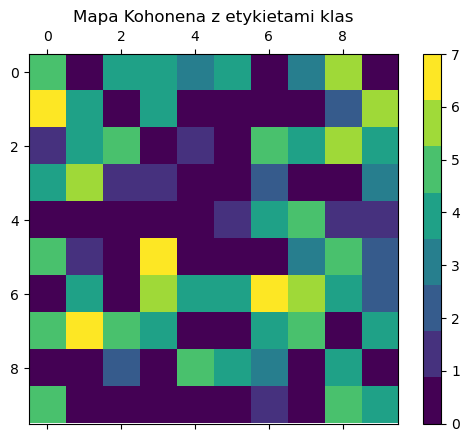

In [143]:
label_map = koh_cube.assign_labels(cube_data, cube_labels)
koh_cube.plot_kohonen_map(label_map)

In [144]:
koh_cube.calculate_silhouette_score(cube_data, cube_labels)

0.40308222802806354

# Hexagon

In [6]:
koh_hexagon = KOH(m=5, n=5, dim=2, alpha=1, sigma=1)
koh_hexagon.train(hexagon_data, num_iterations=100, labels=hexagon_labels, show_estimated_time=True)

Iteracja 100/100 | alpha: 0.3716 | sigma: 0.0037 | Estymowany czas pozostały: 0.00 sekund
Accuracy: 0.9700%


Data row 0 assigned to cluster 1
Data row 1 assigned to cluster 0
Data row 2 assigned to cluster 2
Data row 3 assigned to cluster 1
Data row 4 assigned to cluster 2
Data row 5 assigned to cluster 2
Data row 6 assigned to cluster 1
Data row 7 assigned to cluster 1
Data row 8 assigned to cluster 4
Data row 9 assigned to cluster 0
Data row 10 assigned to cluster 4
Data row 11 assigned to cluster 1
Data row 12 assigned to cluster 0
Data row 13 assigned to cluster 2
Data row 14 assigned to cluster 3
Data row 15 assigned to cluster 3
Data row 16 assigned to cluster 1
Data row 17 assigned to cluster 0
Data row 18 assigned to cluster 5
Data row 19 assigned to cluster 0
Data row 20 assigned to cluster 2
Data row 21 assigned to cluster 5
Data row 22 assigned to cluster 1
Data row 23 assigned to cluster 3
Data row 24 assigned to cluster 3
Data row 25 assigned to cluster 5
Data row 26 assigned to cluster 4
Data row 27 assigned to cluster 0
Data row 28 assigned to cluster 1
Data row 29 assigned to 

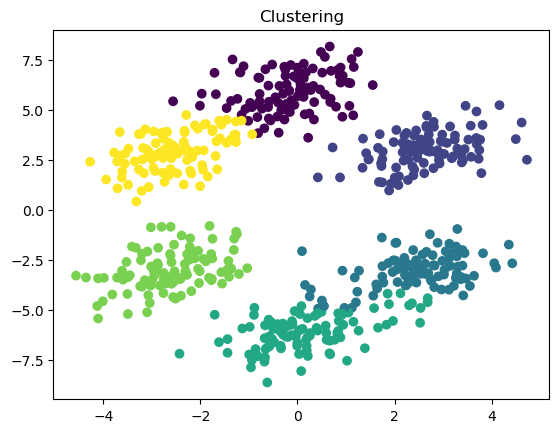

In [7]:
koh_hexagon.plot_clusters(hexagon_data, hexagon_labels)

In [8]:
koh_hexagon.calculate_silhouette_score(hexagon_data, hexagon_labels)

0.5857713966124766

# MNIST

In [82]:
MNIST_data_flattened = MNIST_data.reshape(-1, 784)

koh_mnist = KOH(m=10, n=10, dim=784, alpha=1, sigma=1)
koh_mnist.train(MNIST_data_flattened, num_iterations=5, labels=MNIST_labels, show_estimated_time=True)

Iteracja 5/5 | alpha: 0.9608 | sigma: 0.0095 | Estymowany czas pozostały: 0.00 sekundd
Accuracy: 0.6662%


In [83]:
koh_mnist.plot_clusters(MNIST_data_flattened, MNIST_labels)

Data row 0 assigned to cluster 3
Data row 1 assigned to cluster 0
Data row 2 assigned to cluster 1
Data row 3 assigned to cluster 1
Data row 4 assigned to cluster 9
Data row 5 assigned to cluster 2
Data row 6 assigned to cluster 5
Data row 7 assigned to cluster 3
Data row 8 assigned to cluster 5
Data row 9 assigned to cluster 4
Data row 10 assigned to cluster 3
Data row 11 assigned to cluster 5
Data row 12 assigned to cluster 3
Data row 13 assigned to cluster 6
Data row 14 assigned to cluster 1
Data row 15 assigned to cluster 9
Data row 16 assigned to cluster 2
Data row 17 assigned to cluster 8
Data row 18 assigned to cluster 6
Data row 19 assigned to cluster 9
Data row 20 assigned to cluster 4
Data row 21 assigned to cluster 0
Data row 22 assigned to cluster 4
Data row 23 assigned to cluster 1
Data row 24 assigned to cluster 5
Data row 25 assigned to cluster 2
Data row 26 assigned to cluster 9
Data row 27 assigned to cluster 3
Data row 28 assigned to cluster 9
Data row 29 assigned to 

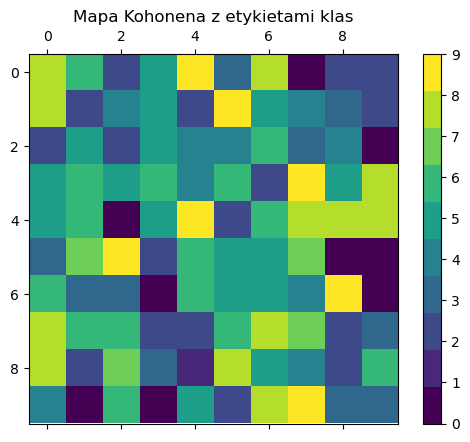

In [84]:
label_map = koh_mnist.assign_labels(MNIST_data_flattened, MNIST_labels)
koh_mnist.plot_kohonen_map(label_map)

In [18]:
# Ta opcja działa dużo dłużej
koh_mnist = KOH(m=10, n=10, dim=784, alpha=1, sigma=1, neighborhood_func='mexican_hat', topology='hexagonal')
koh_mnist.train(MNIST_data_flattened, num_iterations=5, labels=MNIST_labels, show_estimated_time=True)

Iteracja 5/5 | alpha: 0.9608 | sigma: 0.0095 | Estymowany czas pozostały: 0.00 sekunddd
Accuracy: 0.6662%


In [19]:
koh_mnist.plot_clusters(MNIST_data_flattened, MNIST_labels)

Data row 0 assigned to cluster 3
Data row 1 assigned to cluster 0
Data row 2 assigned to cluster 1
Data row 3 assigned to cluster 1
Data row 4 assigned to cluster 9
Data row 5 assigned to cluster 2
Data row 6 assigned to cluster 5
Data row 7 assigned to cluster 3
Data row 8 assigned to cluster 5
Data row 9 assigned to cluster 4
Data row 10 assigned to cluster 3
Data row 11 assigned to cluster 5
Data row 12 assigned to cluster 3
Data row 13 assigned to cluster 6
Data row 14 assigned to cluster 1
Data row 15 assigned to cluster 9
Data row 16 assigned to cluster 2
Data row 17 assigned to cluster 8
Data row 18 assigned to cluster 6
Data row 19 assigned to cluster 9
Data row 20 assigned to cluster 4
Data row 21 assigned to cluster 0
Data row 22 assigned to cluster 4
Data row 23 assigned to cluster 1
Data row 24 assigned to cluster 5
Data row 25 assigned to cluster 2
Data row 26 assigned to cluster 9
Data row 27 assigned to cluster 3
Data row 28 assigned to cluster 9
Data row 29 assigned to 

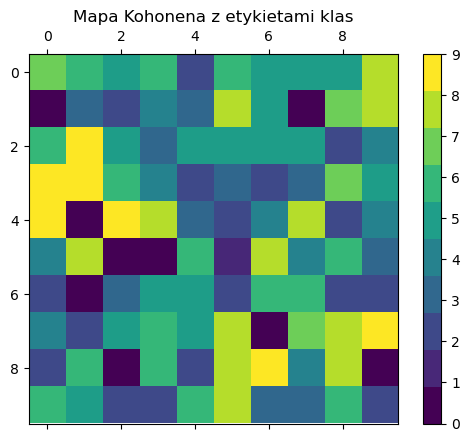

In [20]:
label_map = koh_mnist.assign_labels(MNIST_data_flattened, MNIST_labels)
koh_mnist.plot_kohonen_map(label_map)

In [21]:
koh_mnist.calculate_silhouette_score(MNIST_data_flattened, MNIST_labels)

0.042750593525671426

# HARUS

In [13]:
koh_harus = KOH(m=10, n=10, dim=561, alpha=1, sigma=0.8)
koh_harus.train(HARUS_data, num_iterations=5, labels=HARUS_labels, show_estimated_time=True)

Iteracja 5/5 | alpha: 0.9608 | sigma: 0.0076 | Estymowany czas pozostały: 0.00 sekundd
Accuracy: 0.1468%


In [14]:
koh_harus.plot_clusters(HARUS_data, HARUS_labels)

Data row 0 assigned to cluster 2
Data row 1 assigned to cluster 2
Data row 2 assigned to cluster 2
Data row 3 assigned to cluster 2
Data row 4 assigned to cluster 2
Data row 5 assigned to cluster 2
Data row 6 assigned to cluster 2
Data row 7 assigned to cluster 2
Data row 8 assigned to cluster 2
Data row 9 assigned to cluster 2
Data row 10 assigned to cluster 2
Data row 11 assigned to cluster 2
Data row 12 assigned to cluster 2
Data row 13 assigned to cluster 2
Data row 14 assigned to cluster 2
Data row 15 assigned to cluster 2
Data row 16 assigned to cluster 2
Data row 17 assigned to cluster 2
Data row 18 assigned to cluster 2
Data row 19 assigned to cluster 2
Data row 20 assigned to cluster 2
Data row 21 assigned to cluster 2
Data row 22 assigned to cluster 2
Data row 23 assigned to cluster 2
Data row 24 assigned to cluster 2
Data row 25 assigned to cluster 2
Data row 26 assigned to cluster 2
Data row 27 assigned to cluster 2
Data row 28 assigned to cluster 2
Data row 29 assigned to 

In [25]:
koh_harus.calculate_silhouette_score(HARUS_data, HARUS_labels)

0.06325945978110295

In [22]:
koh_harus = KOH(m=10, n=10, dim=561, alpha=1, sigma=0.8, neighborhood_func='mexican_hat', topology='hexagonal')
koh_harus.train(HARUS_data, num_iterations=5, labels=HARUS_labels, show_estimated_time=True)

Iteracja 5/5 | alpha: 0.9608 | sigma: 0.0076 | Estymowany czas pozostały: 0.00 sekund
Accuracy: 0.1468%


In [23]:
koh_harus.plot_clusters(HARUS_data, HARUS_labels)

Data row 0 assigned to cluster 2
Data row 1 assigned to cluster 2
Data row 2 assigned to cluster 2
Data row 3 assigned to cluster 2
Data row 4 assigned to cluster 2
Data row 5 assigned to cluster 2
Data row 6 assigned to cluster 2
Data row 7 assigned to cluster 2
Data row 8 assigned to cluster 2
Data row 9 assigned to cluster 2
Data row 10 assigned to cluster 2
Data row 11 assigned to cluster 2
Data row 12 assigned to cluster 2
Data row 13 assigned to cluster 2
Data row 14 assigned to cluster 2
Data row 15 assigned to cluster 2
Data row 16 assigned to cluster 2
Data row 17 assigned to cluster 2
Data row 18 assigned to cluster 2
Data row 19 assigned to cluster 2
Data row 20 assigned to cluster 2
Data row 21 assigned to cluster 2
Data row 22 assigned to cluster 2
Data row 23 assigned to cluster 2
Data row 24 assigned to cluster 2
Data row 25 assigned to cluster 2
Data row 26 assigned to cluster 2
Data row 27 assigned to cluster 2
Data row 28 assigned to cluster 2
Data row 29 assigned to 

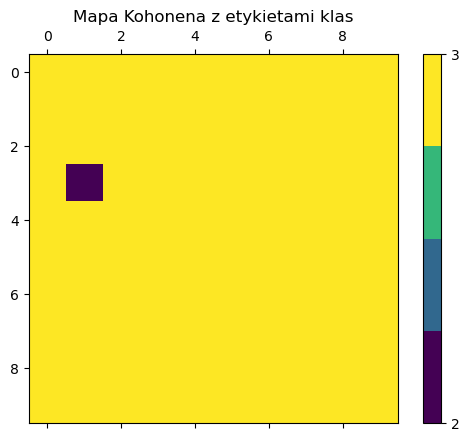

In [24]:
label_map = koh_harus.assign_labels(HARUS_data, HARUS_labels)
koh_harus.plot_kohonen_map(label_map)

## Obserwacje
##### Większa ilość wymiarów wymaga jeszcze bardziej precyzyjnych parametrów. Jednak przy dobrych ustawieniach ilość epoch nie musi być stosunkowo taka duża. (niestety dla zbioru HARUS nie udało mi się dobrać odpowiednich) P.S, zawsze chciałem zbiór MNIST przepuścić przez własną sieć :)